In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, roc_auc_score, classification_report
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import joblib


In [2]:
dataset = pd.read_csv('data clean2.csv', sep=None, engine='python', on_bad_lines='skip')

In [3]:
def clean_numeric(val):
    try:
        return float(val.split('.')[0])
    except:
        return np.nan

In [4]:
for col in ['trestbps', 'chol', 'thalch', 'oldpeak']:
    dataset[col] = dataset[col].apply(clean_numeric)

In [5]:
dataset['target'] = dataset['num'].apply(lambda x: 1 if x > 0 else 0)

In [6]:
fitur = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs',
         'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
X = dataset[fitur]
y = dataset['target']

In [7]:
for kolom in X.select_dtypes(include='object').columns:
    X[kolom] = LabelEncoder().fit_transform(X[kolom])

C:\Users\user\AppData\Local\Temp\ipykernel_16904\3180446530.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[kolom] = LabelEncoder().fit_transform(X[kolom])
C:\Users\user\AppData\Local\Temp\ipykernel_16904\3180446530.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[kolom] = LabelEncoder().fit_transform(X[kolom])
C:\Users\user\AppData\Local\Temp\ipykernel_16904\3180446530.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

In [8]:
X = X.fillna(X.mean())

In [9]:
model_rf = RandomForestClassifier(n_estimators=200, criterion='entropy', random_state=0)
rfe = RFE(estimator=model_rf, n_features_to_select=7)
rfe.fit(X, y)
selected_features = X.columns[rfe.support_]
print("Fitur terbaik dari RFE:", list(selected_features))
X_selected = X[selected_features]

Fitur terbaik dari RFE: ['age', 'cp', 'trestbps', 'chol', 'thalch', 'ca', 'thal']


In [10]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=0),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='accuracy'
)
grid_search.fit(X_selected, y)
best_rf = grid_search.best_estimator_
print("Best Parameters dari Grid Search:")
print(grid_search.best_params_)

Best Parameters dari Grid Search:
{'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 100}


In [11]:
best_scores = cross_val_score(best_rf, X_selected, y, cv=5)
print(f"Akurasi setelah Tuning: {best_scores.mean()*100:.2f}% (+/- {best_scores.std()*100:.2f}%)")

Akurasi setelah Tuning: 81.16% (+/- 8.25%)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.25, random_state=0)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(f"Akurasi Final: {accuracy_score(y_test, y_pred)*100:.2f}%")

Confusion Matrix:
 [[ 81  24]
 [ 16 109]]
Akurasi Final: 82.61%


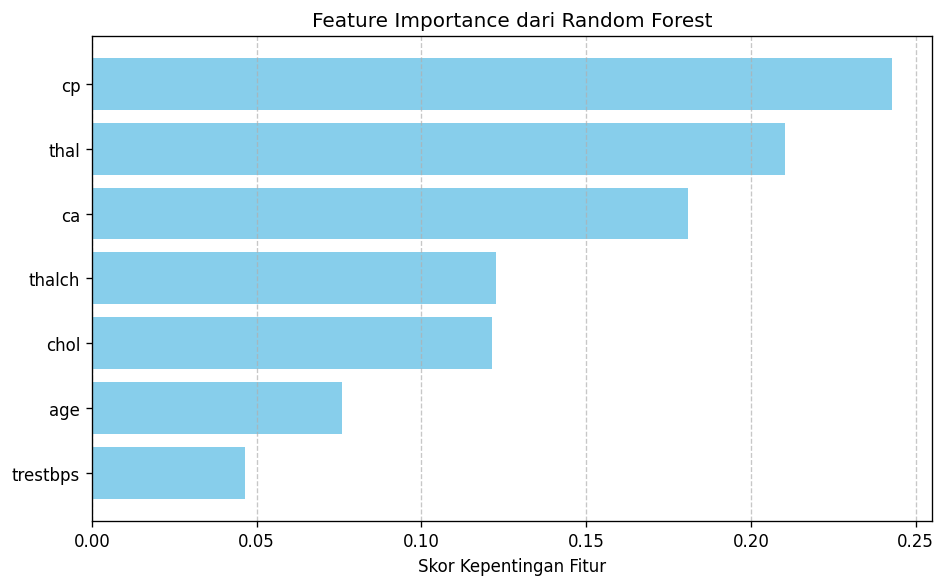

In [13]:
importances = best_rf.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(8, 5), dpi=120)
plt.barh(range(len(indices)), importances[indices], align='center', color='skyblue')
plt.yticks(range(len(indices)), [selected_features[i] for i in indices])
plt.xlabel('Skor Kepentingan Fitur')
plt.title('Feature Importance dari Random Forest')
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [14]:
models = {
    'Random Forest': best_rf,
    'SVM': SVC(probability=True, kernel='rbf', random_state=0),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=0),
    'Logistic Regression': LogisticRegression(class_weight='balanced')
}

results = {}
roc_data = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    
    results[name] = acc
    roc_data[name] = (fpr, tpr, auc)
    
    print(f"\n=== {name} ===")
    print(f"Akurasi: {acc*100:.2f}%")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Tidak Sakit', 'Sakit']))



=== Random Forest ===
Akurasi: 82.61%
Classification Report:
              precision    recall  f1-score   support

 Tidak Sakit       0.84      0.77      0.80       105
       Sakit       0.82      0.87      0.84       125

    accuracy                           0.83       230
   macro avg       0.83      0.82      0.82       230
weighted avg       0.83      0.83      0.83       230


=== SVM ===
Akurasi: 83.91%
Classification Report:
              precision    recall  f1-score   support

 Tidak Sakit       0.85      0.78      0.82       105
       Sakit       0.83      0.89      0.86       125

    accuracy                           0.84       230
   macro avg       0.84      0.83      0.84       230
weighted avg       0.84      0.84      0.84       230


=== KNN ===
Akurasi: 81.74%
Classification Report:
              precision    recall  f1-score   support

 Tidak Sakit       0.81      0.79      0.80       105
       Sakit       0.83      0.84      0.83       125

    accuracy    

## Baru

In [16]:
feature_importance_all = {}
for name, model in models.items():
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importance = np.abs(model.coef_[0])
    else:
        result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=0, n_jobs=-1)
        importance = result.importances_mean
    feature_importance_all[name] = importance

## Baru

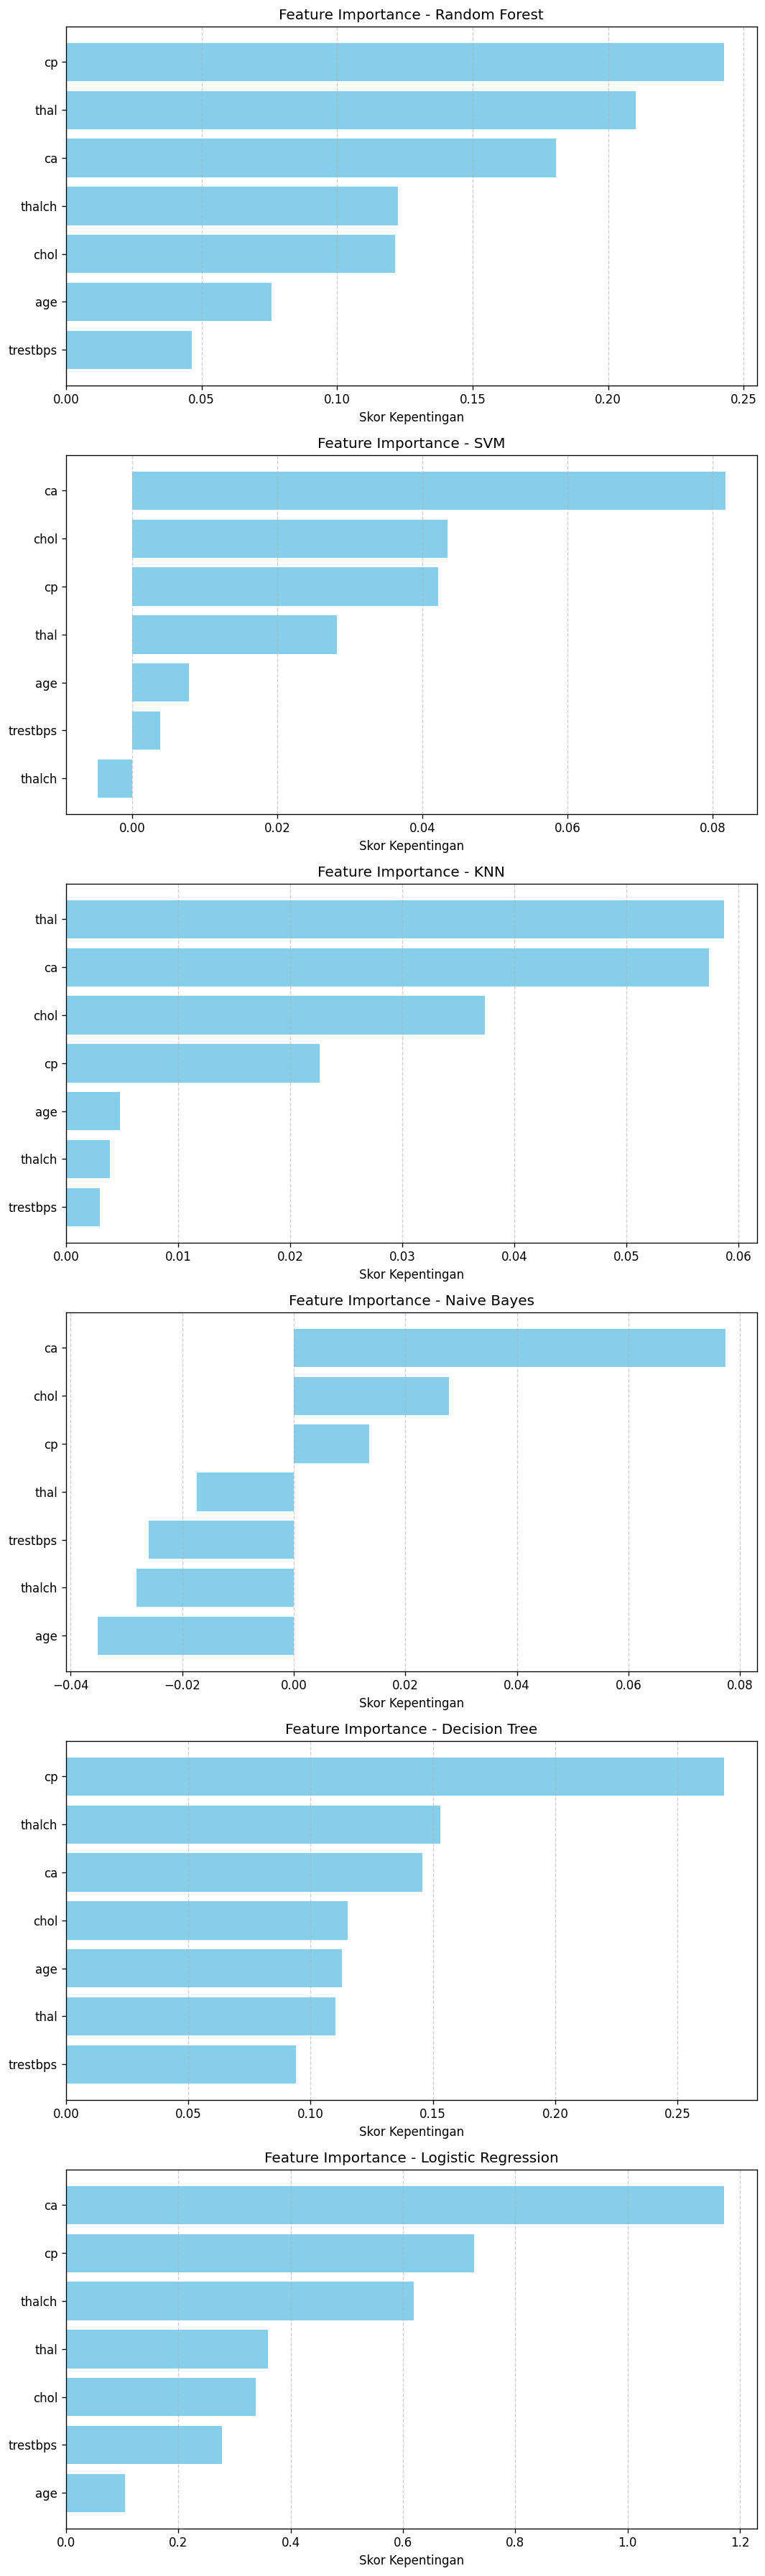

In [17]:
fig, axes = plt.subplots(nrows=len(feature_importance_all), ncols=1, figsize=(9, 5 * len(feature_importance_all)), dpi=120)

if len(feature_importance_all) == 1:
    axes = [axes]

for ax, (model_name, importances) in zip(axes, feature_importance_all.items()):
    indices = np.argsort(importances)
    ax.barh(range(len(indices)), importances[indices], color='skyblue')
    ax.set_yticks(range(len(indices)))
    ax.set_yticklabels([selected_features[i] for i in indices])
    ax.set_title(f'Feature Importance - {model_name}')
    ax.set_xlabel('Skor Kepentingan')
    ax.grid(axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

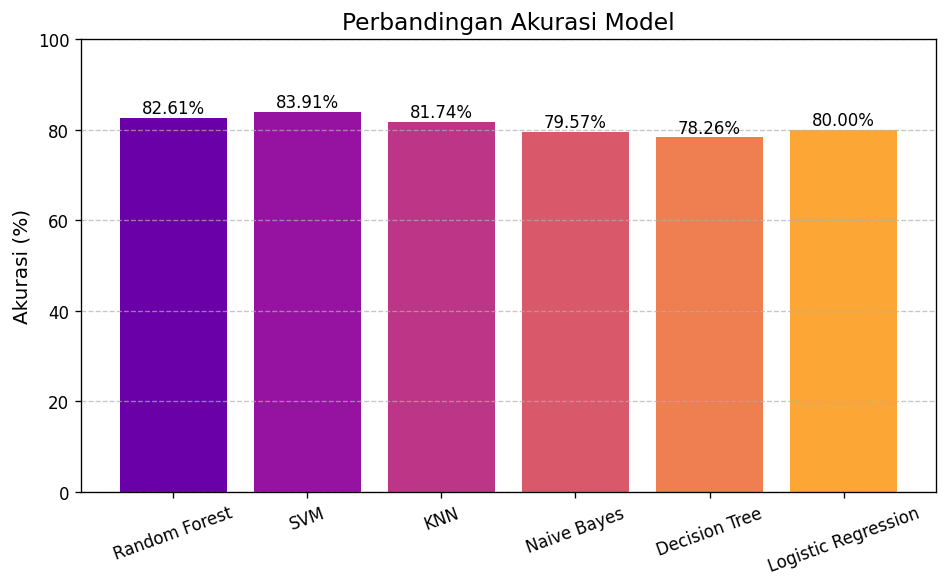

In [18]:
plt.figure(figsize=(8, 5), dpi=120)
model_names = list(results.keys())
accuracies = [results[m] * 100 for m in model_names]
colors = plt.cm.plasma(np.linspace(0.2, 0.8, len(model_names)))

plt.bar(model_names, accuracies, color=colors)
plt.ylabel('Akurasi (%)', fontsize=12)
plt.title('Perbandingan Akurasi Model', fontsize=14)
plt.ylim(0, 100)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 1, f"{acc:.2f}%", ha='center', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


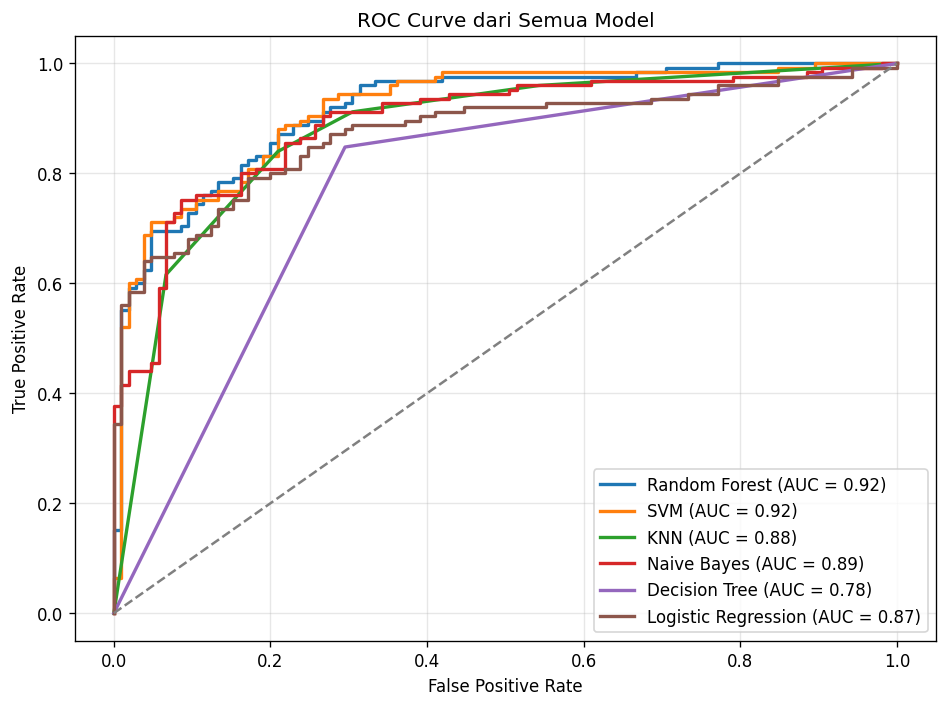

In [19]:
plt.figure(figsize=(8, 6), dpi=120)
for name, (fpr, tpr, auc) in roc_data.items():
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve dari Semua Model')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()